In [212]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from matplotlib.lines import Line2D
from sklearn.linear_model import LinearRegression as sk_lin_reg
from patsy import build_design_matrices, dmatrices
import causalpy as cp
from causalpy.pymc_experiments import InversePropensityWeighting
from causalpy.pymc_models import PropensityScore
seed = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Simulated Data

In [213]:
df1 = pd.DataFrame(np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=10000), columns=['x1', 'x2'])
df1['trt'] = np.where(-0.5 + 0.25 * df1['x1'] + 0.75 * df1['x2'] +  np.random.normal(0, 1, size=10000) > 0, 1, 0)
df1['outcome'] = 2 * df1['trt'] + df1['x1'] + df1['x2'] + np.random.normal(0, 1, size=10000)
df1

,x1,x2,trt,outcome
0,-2.200034,-0.037349,0,-1.416800
1,0.624063,0.414133,1,4.352858
2,1.667157,1.626585,1,5.820789
3,-2.398404,-1.260821,0,-3.588892
4,-0.805269,0.960588,0,-0.938039
...,...,...,...,...
9995,1.208452,1.147621,1,5.845166
9996,1.076350,1.969902,0,2.901360
9997,0.761807,1.726441,1,2.558676
9998,0.159082,0.267265,1,1.979872


In [214]:
result1 = cp.pymc_experiments.InversePropensityWeighting(
         df1,
         formula="trt ~ 1 + x1 + x2",
         outcome_variable ="outcome",
         weighting_scheme="robust",
         model=cp.pymc_models.PropensityScore(
             sample_kwargs={
                 "draws": 1000,
                 "target_accept": 0.95,
                 "random_seed": seed,
                 "progressbar": False,
             },
         ),
)

result1

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


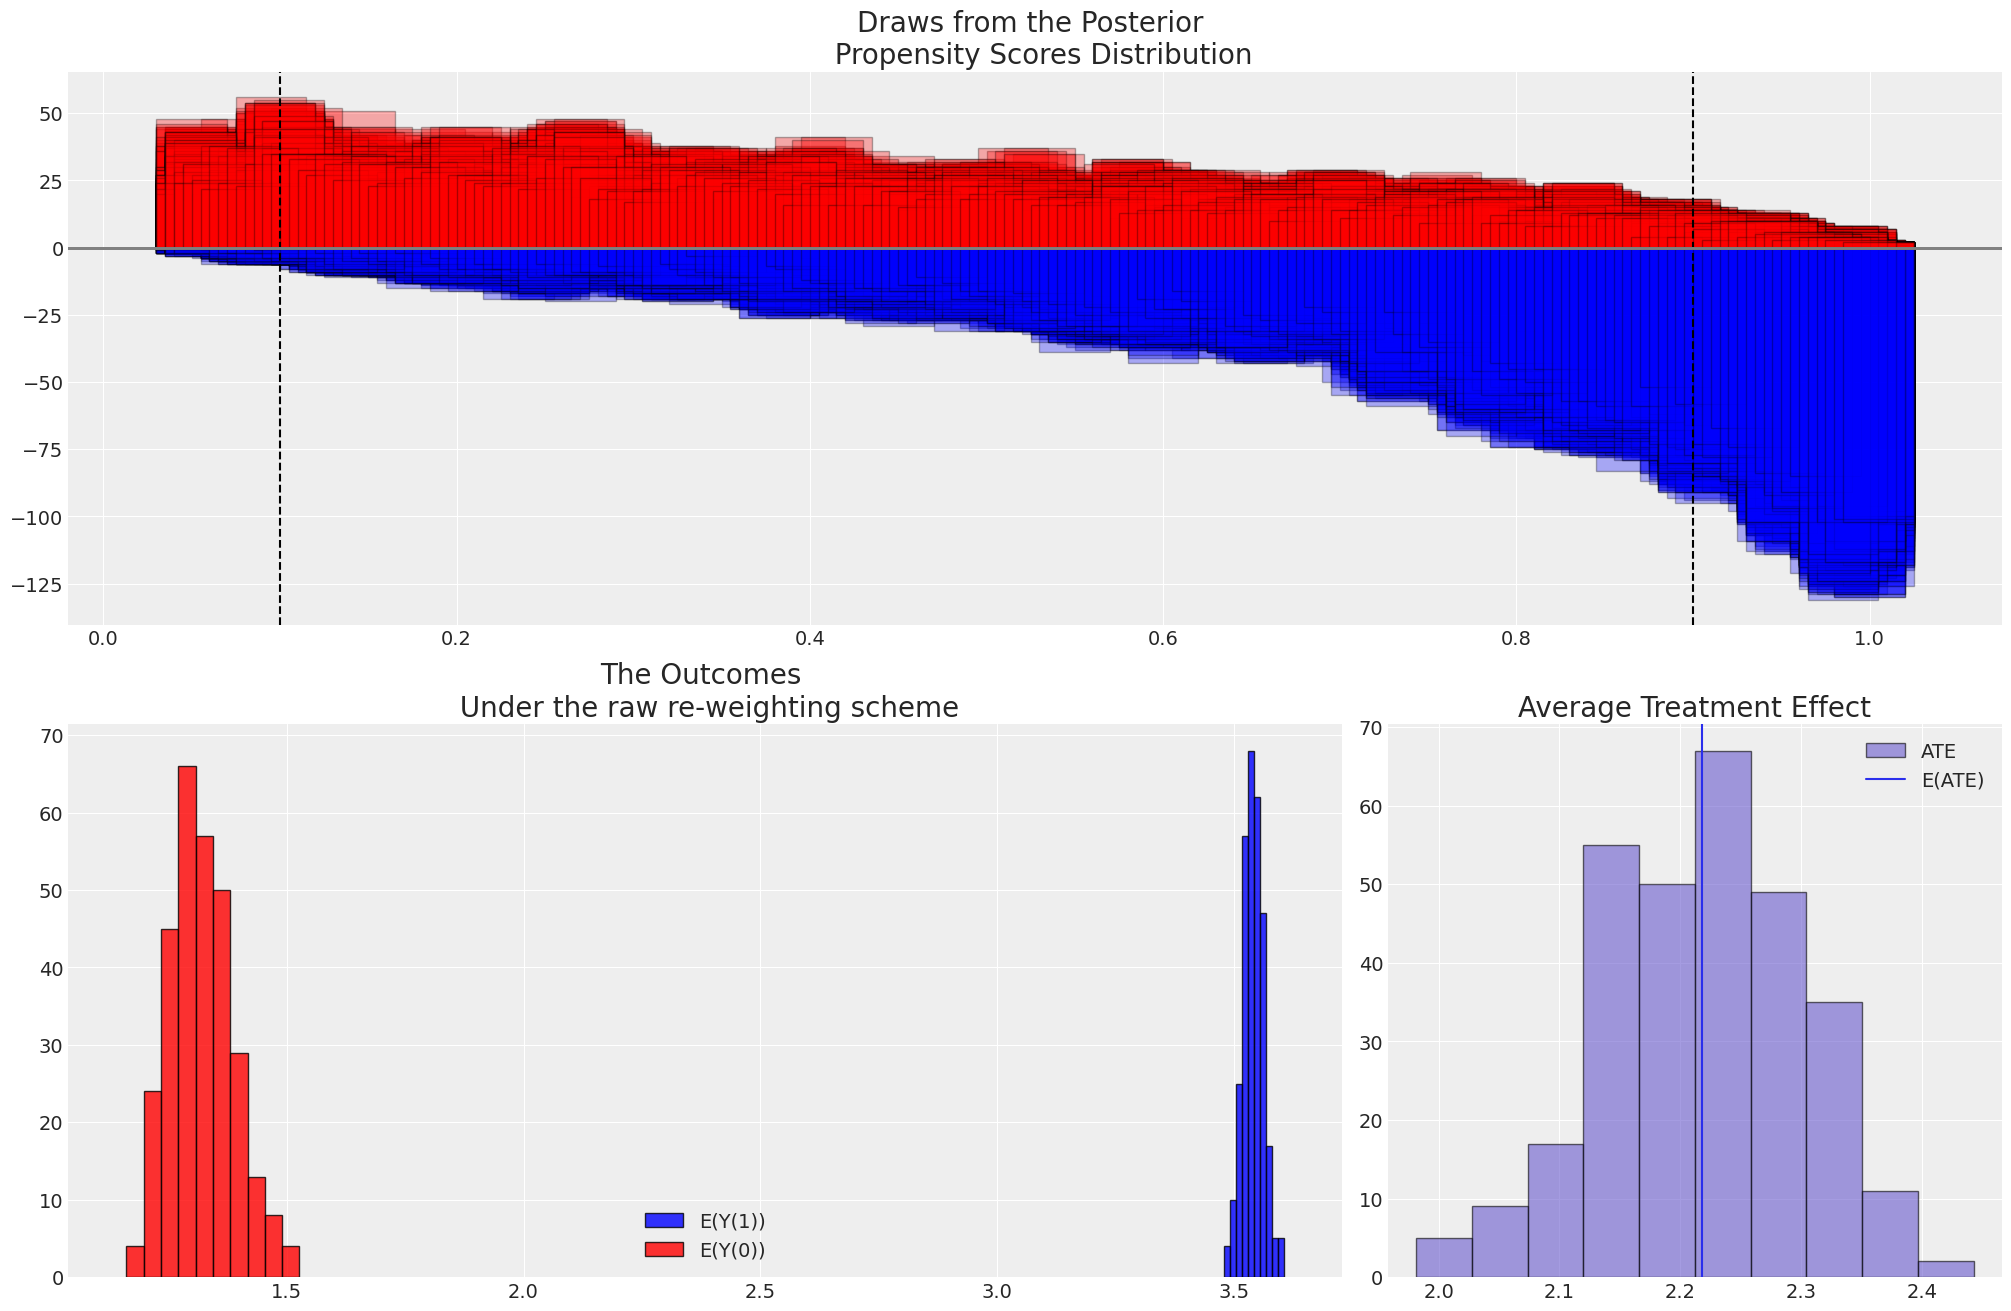

In [216]:
result1.plot_ATE(method='raw');

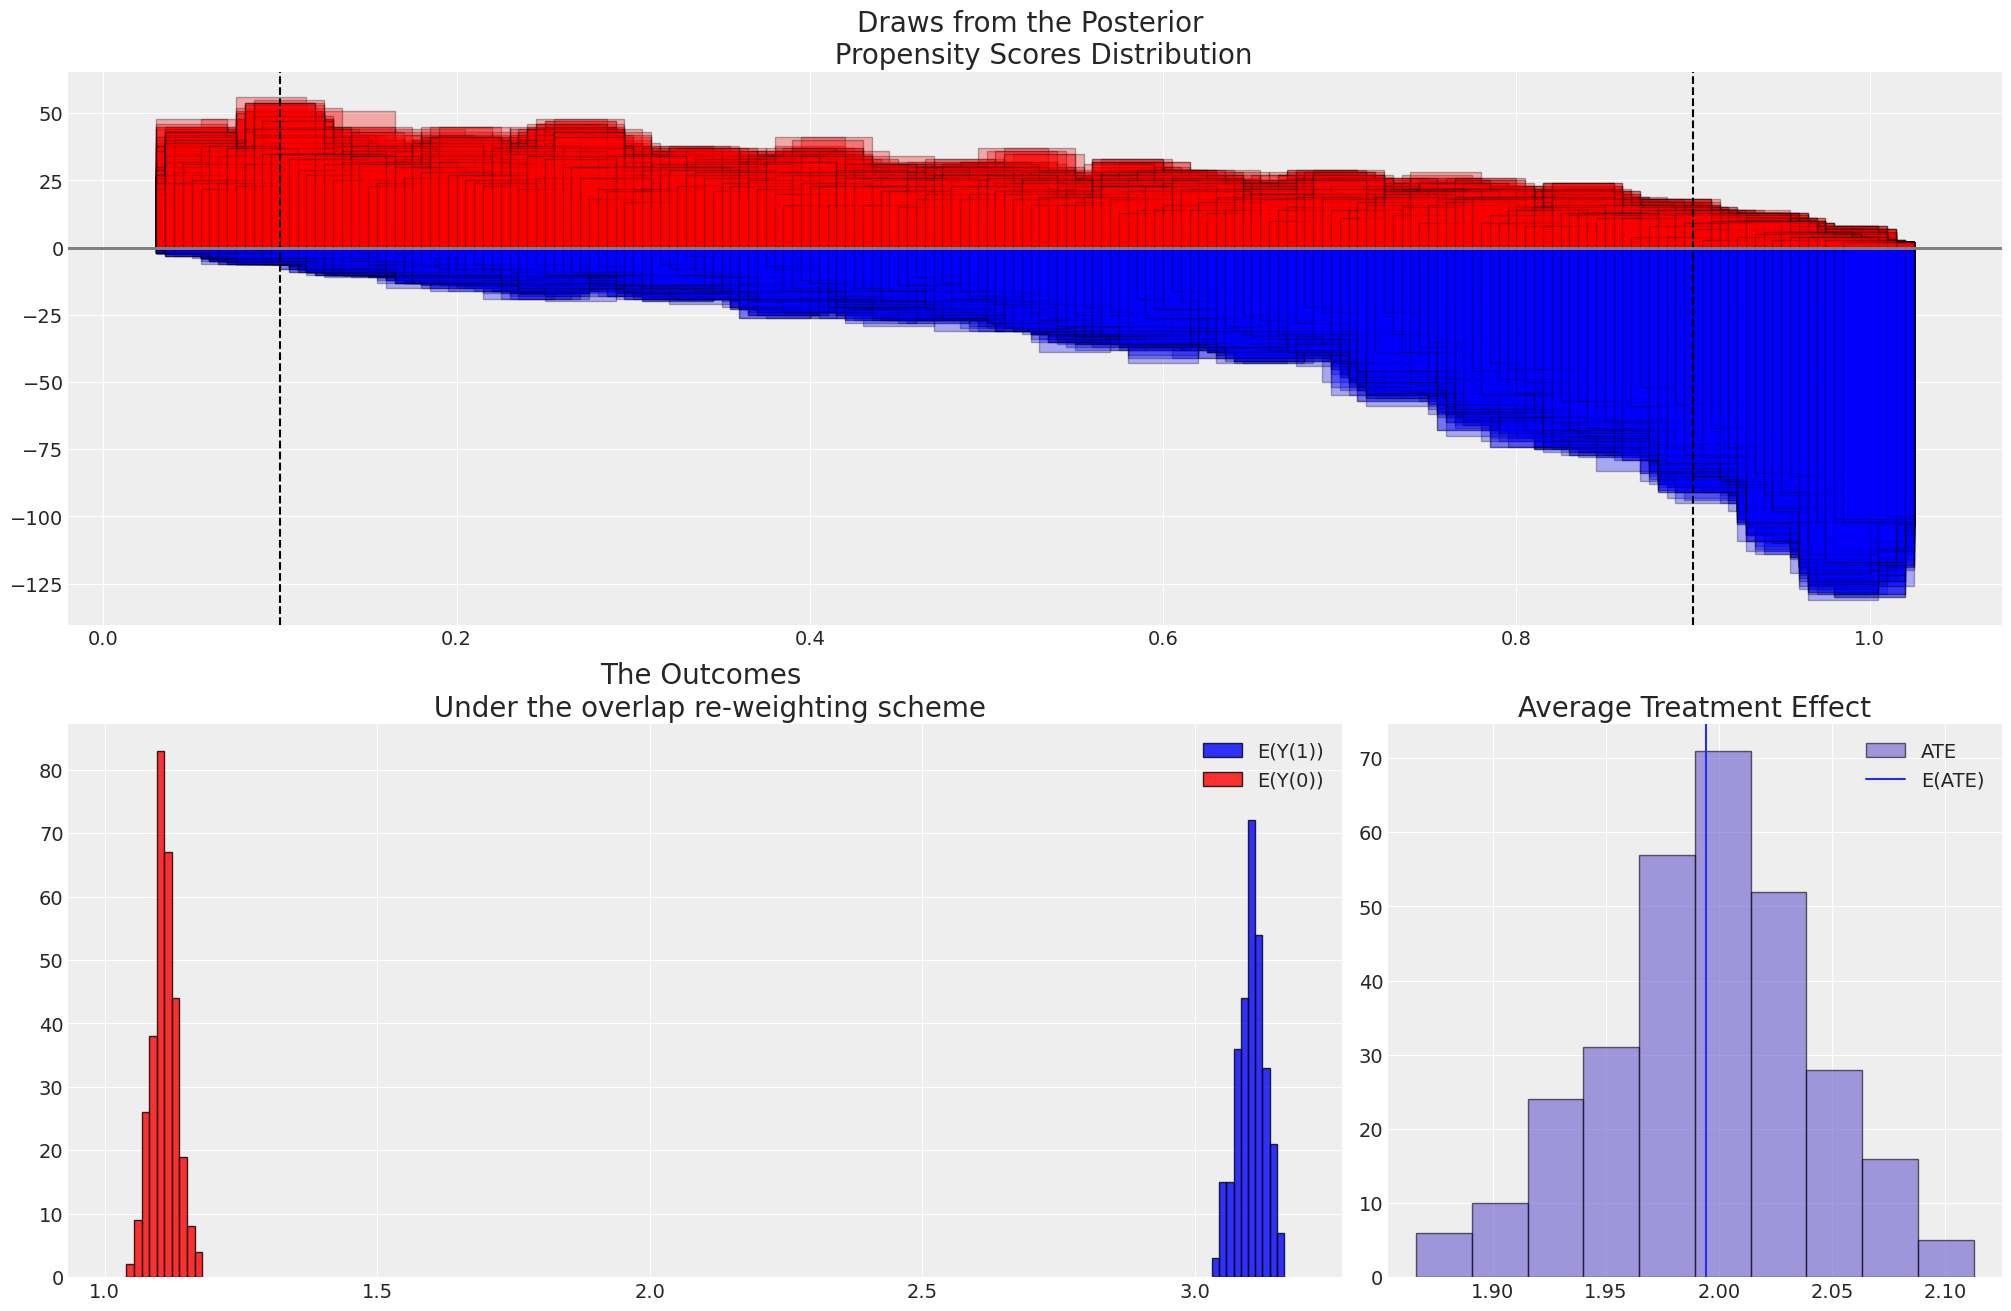

In [215]:
result1.plot_ATE(method='overlap');

## NHEFS Data

In [221]:

result = cp.pymc_experiments.InversePropensityWeighting(
         df,
         formula="""trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2""",
         outcome_variable ="outcome",
         weighting_scheme="robust",
         model=cp.pymc_models.PropensityScore(
             sample_kwargs={
                 "draws": 1000,
                 "target_accept": 0.95,
                 "random_seed": seed,
                 "progressbar": False,
             },
         ),
)

result

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 48 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


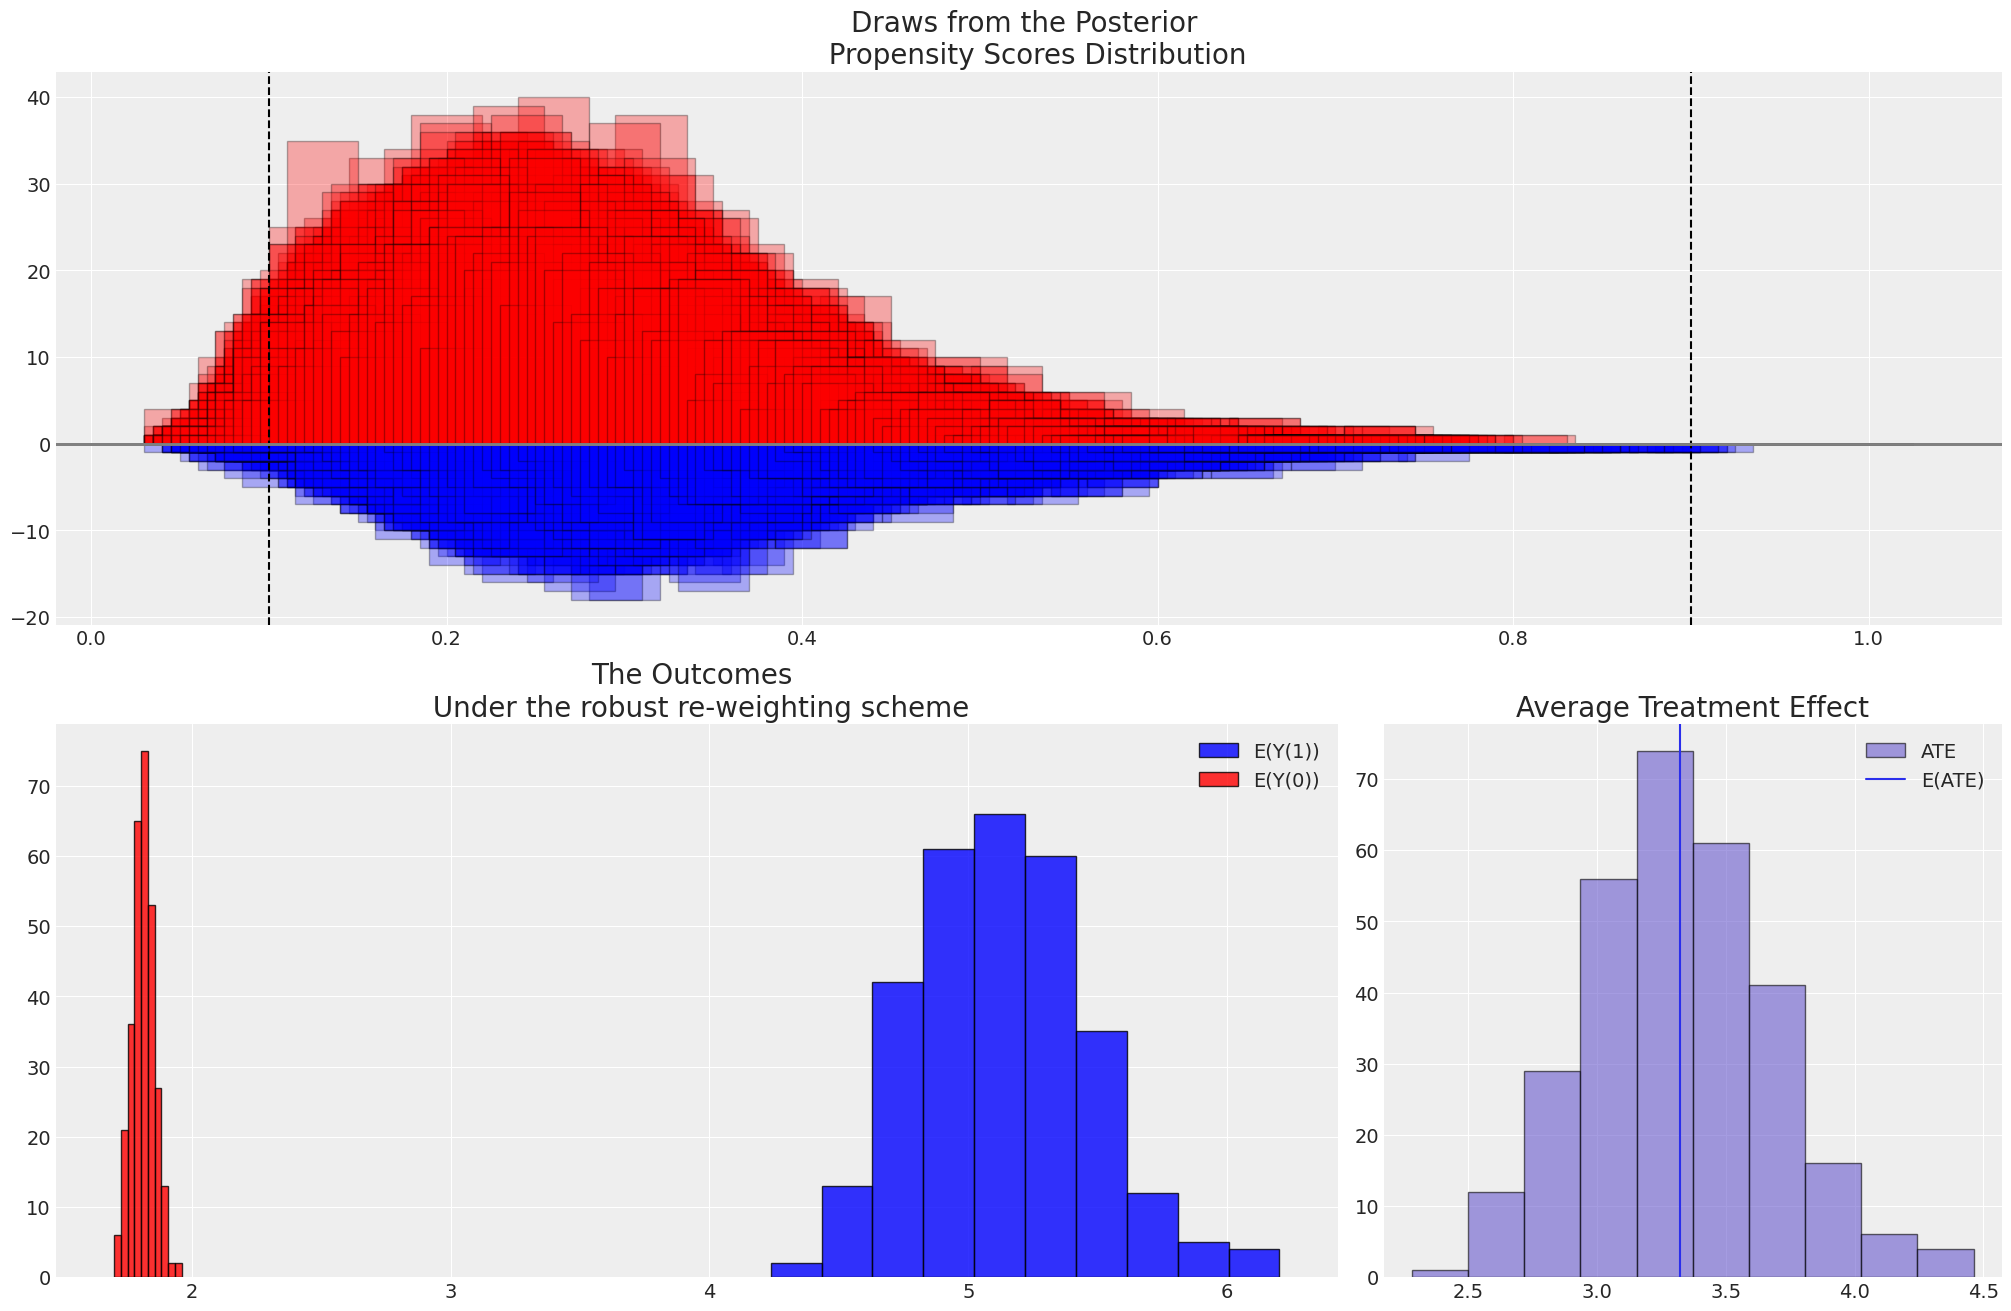

In [228]:
result.plot_ATE(method='robust');

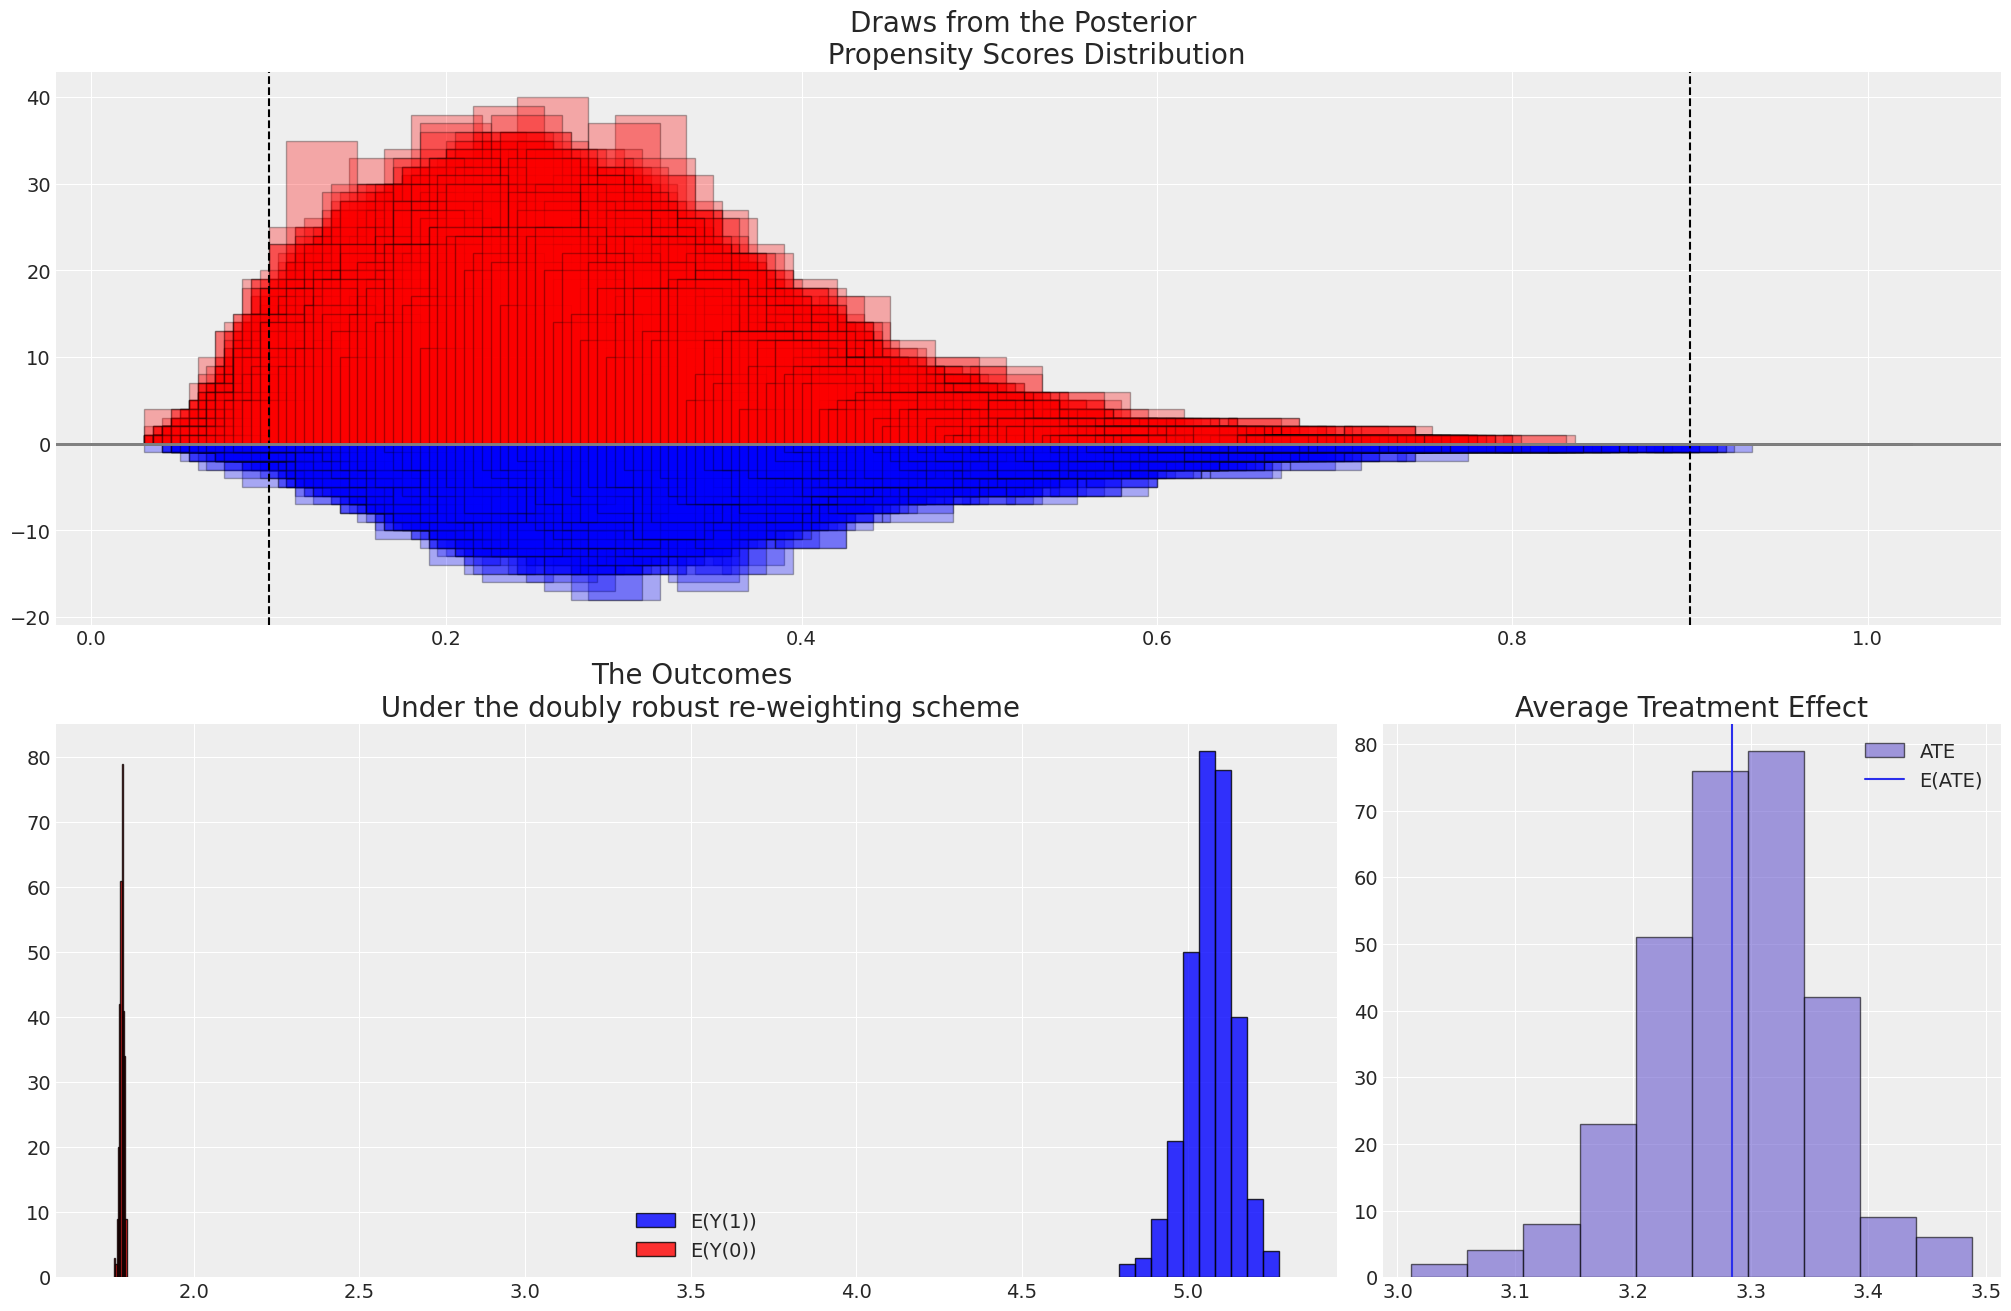

In [223]:
result.plot_ATE(method='doubly robust');

## Evaluating Balance

In [247]:
df

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2,trt,outcome
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841,0,-10.093960
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576,0,2.604970
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676,0,9.414486
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809,0,4.990117
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361,0,4.989251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1561,47,0,1,20,31,84.94,0,0,0,0,0,0,0,0,2209,7214.8036,400,961,0,8.500028
1562,45,0,0,40,29,63.05,0,0,0,0,0,0,0,0,2025,3975.3025,1600,841,0,1.360117
1563,47,0,1,20,31,57.72,0,0,0,0,0,0,0,0,2209,3331.5984,400,961,0,3.514970
1564,68,0,0,15,46,52.39,1,0,0,0,0,0,1,0,4624,2744.7121,225,2116,0,4.762639


In [262]:
def weighted_percentile(data, weights, perc):
    """
    perc : percentile in [0-1]!
    """
    ix = np.argsort(data)
    data = data[ix] # sort data
    weights = weights[ix] # sort weights
    cdf = (np.cumsum(weights) - 0.5 * weights) / np.sum(weights) # 'like' a CDF function
    return np.interp(perc, cdf, data)


def plot_balance_ecdf(covariate, idata, df):
    ps = az.extract(idata)['p']
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    raw_trt = [weighted_percentile(df[df['trt'] == 1][covariate].values, np.ones(len(df[df['trt'] == 1])), p) for p in np.linspace(0, 1, 100)]
    raw_ntrt = [weighted_percentile(df[df['trt'] == 0][covariate].values, np.ones(len(df[df['trt'] == 0])), p) for p in np.linspace(0, 1, 100)]
    w_trt = [weighted_percentile(df[df['trt'] == 1][covariate].values, ps[df['trt'] == 1, 0], p) for p in np.linspace(0, 1, 100)]
    w_ntrt = [weighted_percentile(df[df['trt'] == 0][covariate].values, ps[df['trt'] == 0, 0], p) for p in np.linspace(0, 1, 100)]
    axs[0].plot(raw_trt, color='blue')
    axs[0].plot(raw_ntrt, color='red')
    axs[0].set_title("Raw ECDF")
    axs[1].set_title("Weighted ECDF")
    axs[1].plot(w_trt, color='blue')
    axs[1].plot(w_ntrt, color='red')


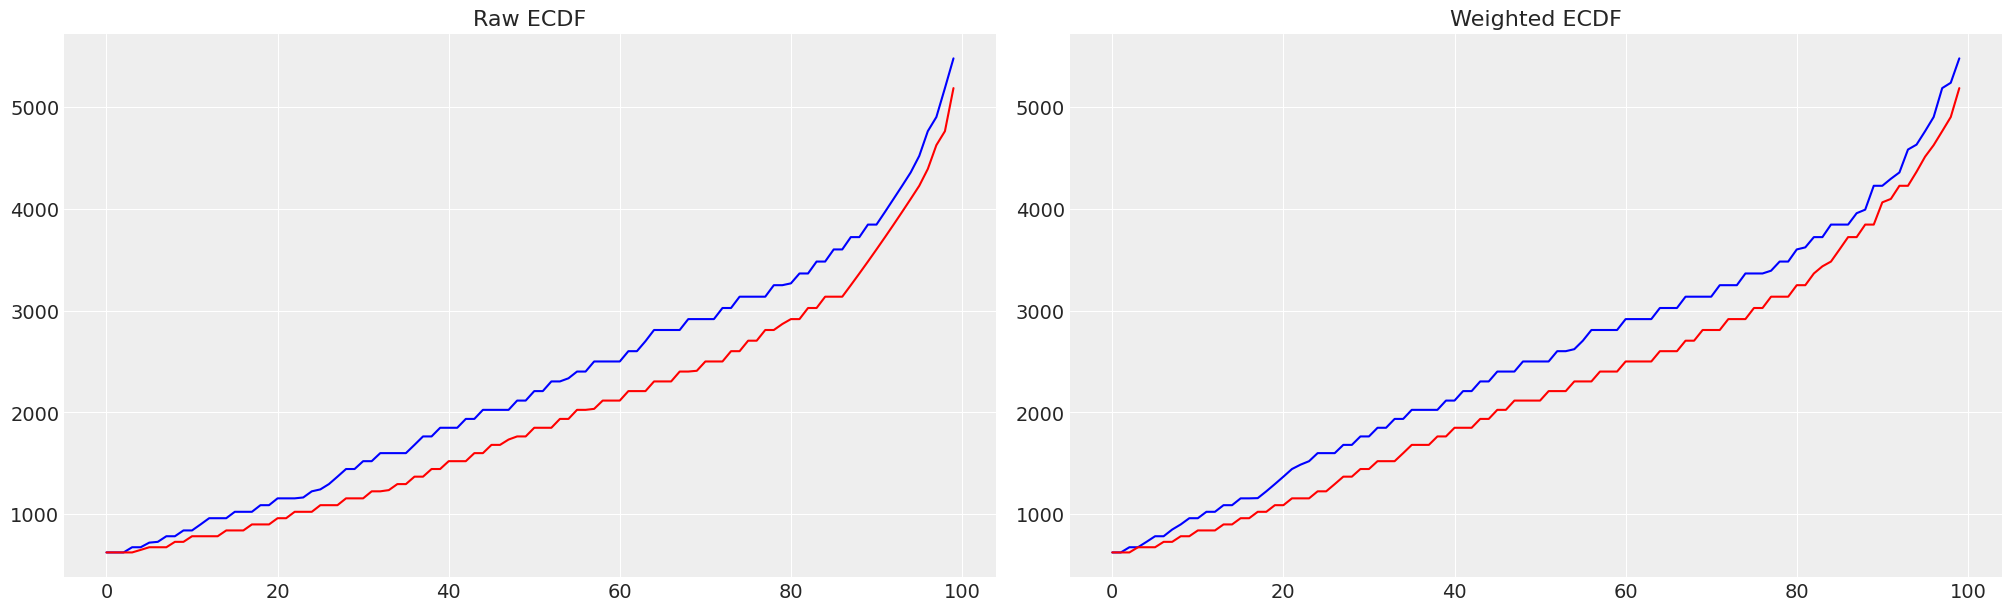

In [263]:
plot_balance_ecdf('age^2', result.idata, df)

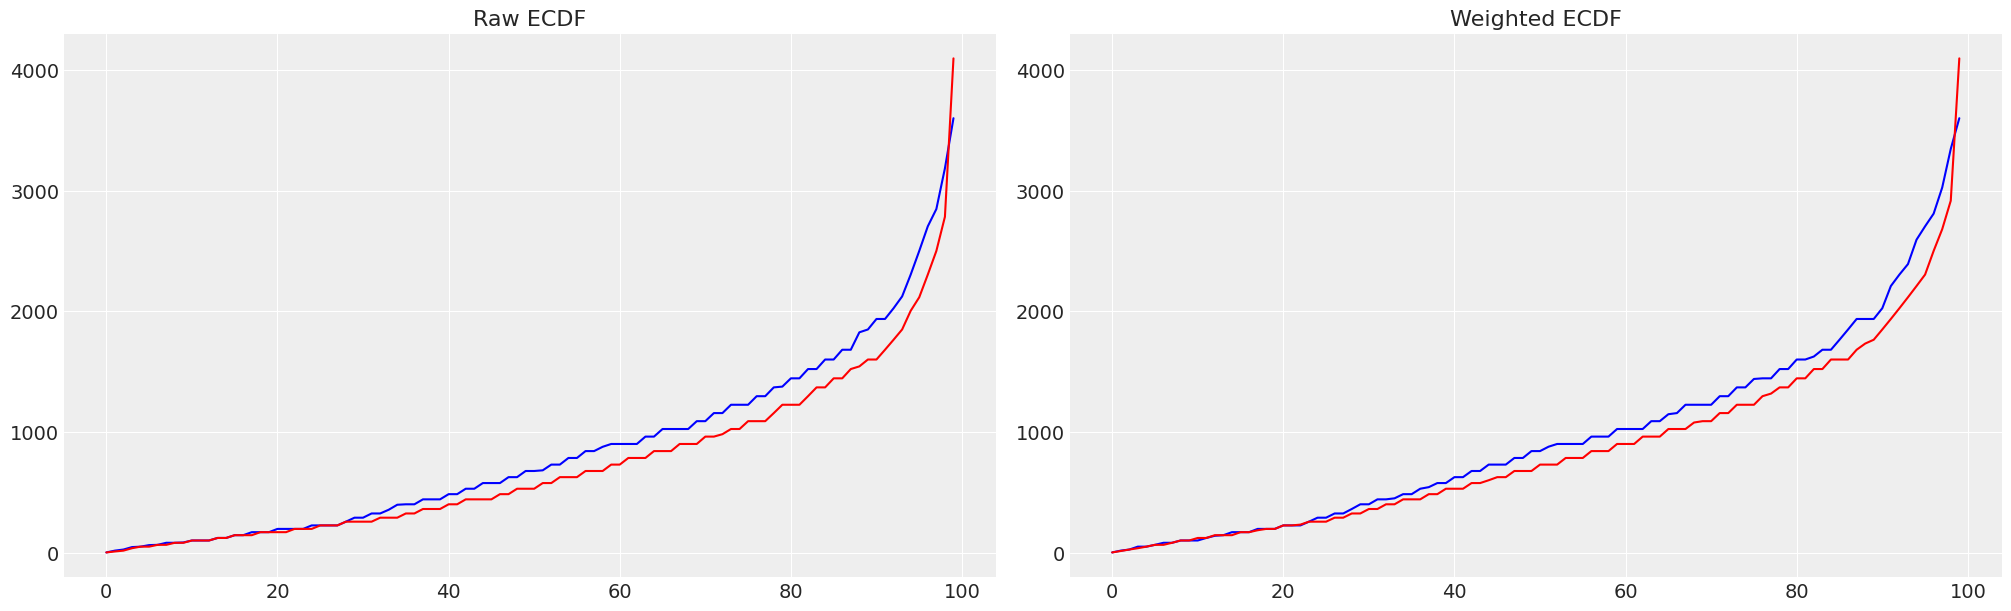

In [264]:
plot_balance_ecdf('smokeyrs^2', result.idata, df)

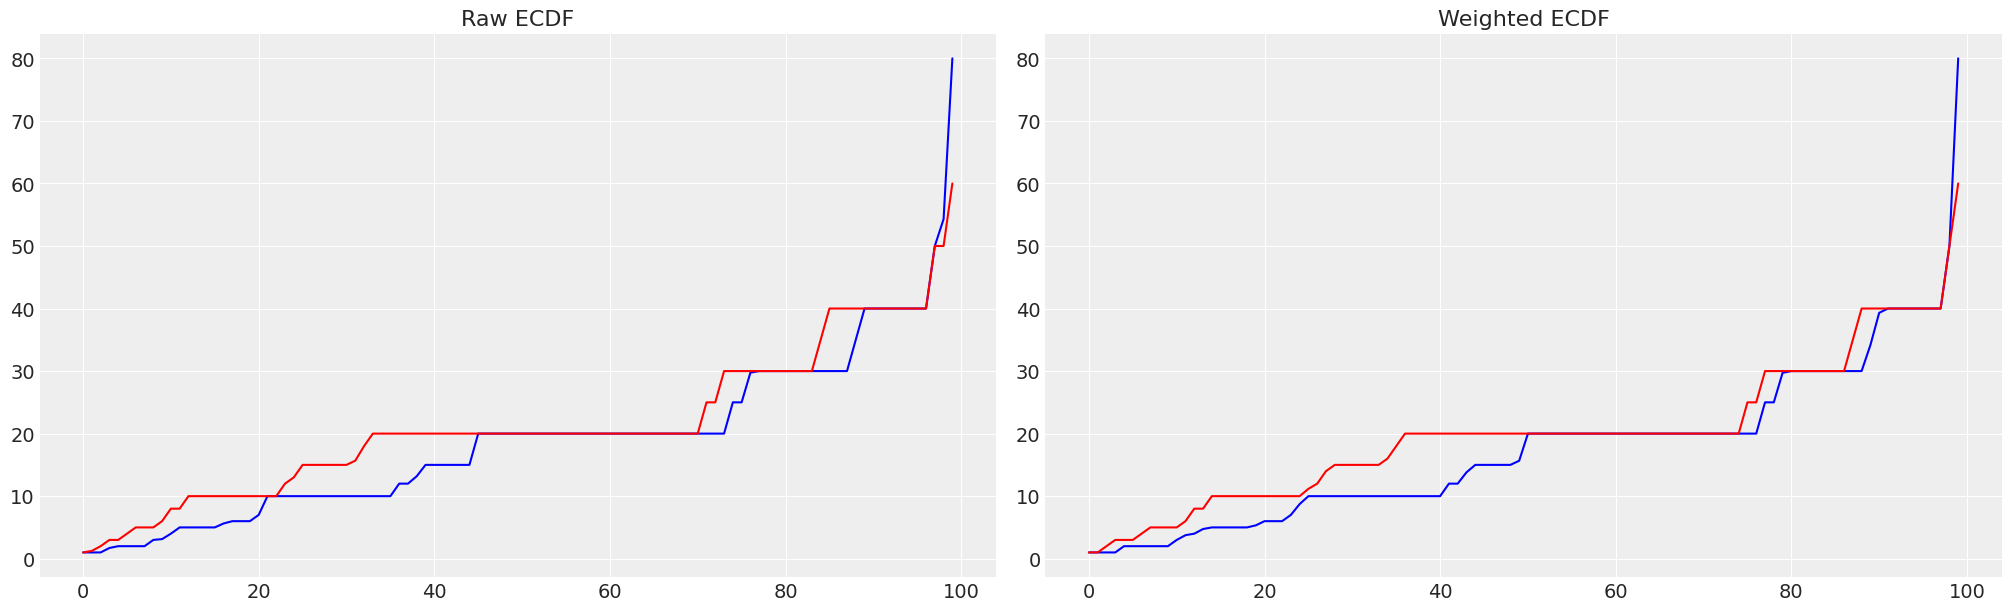

In [265]:
plot_balance_ecdf('smokeintensity', result.idata, df)

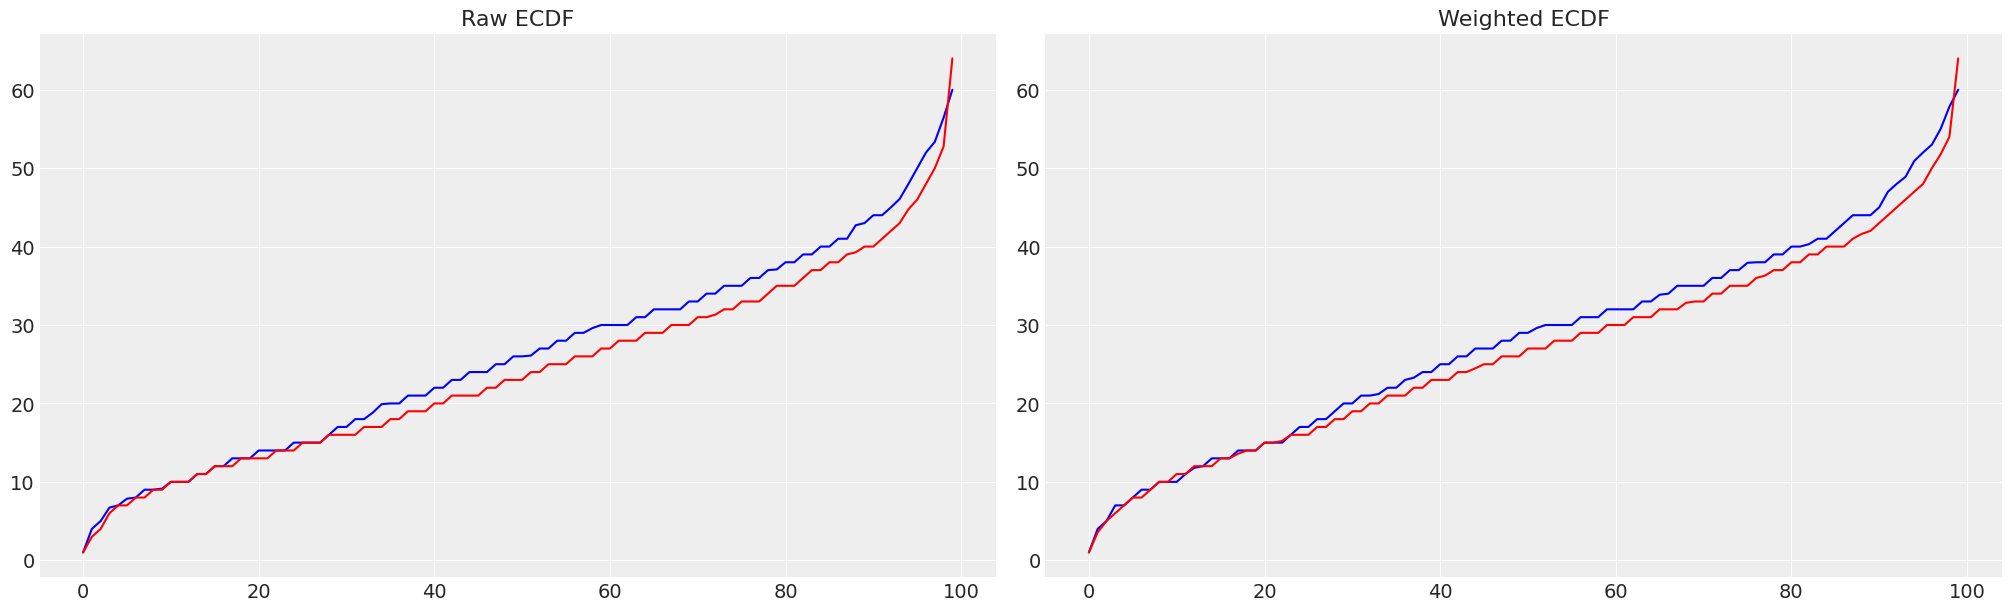

In [266]:
plot_balance_ecdf('smokeyrs', result.idata, df)